In [1]:
import numpy as np
from scipy import linalg
from datetime import datetime
import pandas as pd
import json
from matplotlib.pyplot import*
import calendar
import datetime

In [2]:
class Esn:
    def __init__(self, Nu=1, Ny=1, Nr=100, a=1, conn=100, rho=0.99, Lambda=0, win=1, lsv=True):
        """
         Constructor of the net, prepare and initialize the esn
        :param Nu: input units
        :param Ny: output units
        :param Nr: reservoir size
        :param a: leaking rake
        :param conn: % of connectivity
        :param rho: or lsv to which scale the reservoir
        :param Lambda: regularization parameter
        :param win: input weights scaling
        :param lsv: True - use the largest sing value for normalizing W
        :return:
        """
        self.Nu = Nu  # input dim
        self.Ny = Ny  # output dim
        self.Nr = Nr  # reservoir dim
        self.a = a  # leaking rate
        self.connectivity = conn
        self.Lambda = Lambda  # regularization coefficient
        self.x = np.zeros((self.Nr, 1))  # init the reservoir-net-state

        np.random.seed(5)  # fixed
        # input connections, plus the bias unit
        self.W_in = (np.random.rand(Nr, 1 + Nu) - 0.5) * win  # win is the input scaling
        # reservoir connections, make them sparse!
        self.W = np.random.rand(Nr, Nr) - 0.5
        # -5 halves the values
        eps = 0.5 * conn / 100
        # leave only the conn % of the connections
        self.W[abs(self.W) > eps] = 0
        self.W_out = np.zeros((Nr, Nr))

        if not lsv:
            print ('Computing spectral radius...'),
            t1 = datetime.now()
            rhoW = np.max(np.abs(linalg.eigvals(self.W)))  # esn necessary condition
            self.W *= rho / rhoW

        else:
            print ('Computing largest sing value...'),
            t1 = datetime.now()
            # compute the matrix 2-norm (largest sing. value), esn sufficient condition
            lsv = linalg.norm(self.W, 2)
            self.W *= rho / lsv

        t2 = datetime.now()
        print ('done in '),
        print (t2 - t1).total_seconds(),
        print ("sec")

    def fit_data(self, data, washoutLen=0):
        """
         the reservoir-net-state is updated for each training sample,
         warm-up with washoutLen rows
        :param data: the sequence: a matrix with a pattern per row
        :param washoutLen: transient to discard
        :return: the collected activation state
        """
        # allocated memory for the design (collected states) matrix
        # X instead of  [1|U|X]
        X = np.zeros((1 + self.Nu + self.Nr, data.shape[0] - washoutLen))
        # XX = np.zeros((1 + Nu + Nr, 1 + Nu + Nr))
        # YX = np.zeros((Ny, 1 + Nu + Nr))
        # run the reservoir with the data and collect X, skip washoutLen elements "wash out"
        self.x = np.zeros(self.Nr)  # start from the 0 state
        for t in range(washoutLen):
            u = data[t]
            u = np.append(1, u)
            self.x = (1 - self.a) * self.x \
                     + self.a * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, self.x))

        for t in range(washoutLen, data.shape[0]):
            u = data[t]
            u = np.append(1, u)
            self.x = (1 - self.a) * self.x \
                     + self.a * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, self.x))
            # the states matrix X stores also the input u, for direct input-output connections
            X[:, t - washoutLen] = np.append(u, self.x)
            # x1 = np.vstack((1, u, x))
            # XX += np.dot(x1, x1.T)  # cumulative update of the design matrix
            # YX += np.dot(u, x1.T)  # cumulative update
        return X

    def train_wout(self, X, Yt, Lambda):
        """
         train the output Wout, given X and the relative Yt
        :param X: collected (col-wise) training states, [x(1),x(2),..]
        :param Yt: collected (col-wise) target outputs, [y1,y2,..]
        :param Lambda: regularization param
        :return:
        """
        # also input and bias units contribute for the output
        # X instead of  [1|U|X]
        X_T = X.T
        YX = np.dot(Yt, X_T)
        self.W_out = np.dot(YX, linalg.inv(np.dot(X, X_T) + Lambda * np.eye(1 + self.Nu + self.Nr)))
        # W_out = dot( Yt, linalg.pinv(X) )
        # W_out = np.dot(YX, linalg.inv(XX + Lambda * np.eye(1 + Nu + Nr)))  # using the precomputed XX & YX

    def predict(self, data_test, x, washoutLen=0, generative_mode=True):
        """
         the test method does not modify the reservoir-net-state
         it uses all the data skipping the first washoutLen rows
        :param data_test: sequence, matrix with a sample per row, as many cols as sample-attributes
        :param x: is the starting state of the reservoir
        :param washoutLen: num of patterns just to warm up the state
        :param generative_mode: True, the output is used as the next input (self-feeding);
                                False, takes the input from the data
        :return: a matrix with one predicted output per row one foreach test pattern
        """
        # preallocate the output matrix
        Y = np.zeros((data_test.shape[0] - washoutLen, self.Ny))

        for t in range(washoutLen):
            u = data_test[t]
            u = np.append(1, u)
            # just "warm up" the net state x
            x = (1 - self.a) * x + self.a * np.tanh(
                np.dot(self.W_in, u) + np.dot(self.W, x))

        length = data_test.shape[0] - 1
        # start testing with the left sequence
        u = data_test[washoutLen]
        for t in range(washoutLen, data_test.shape[0]):
            u = np.append(1, u)
            x = (1 - self.a) * x \
                + self.a * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, x))

            y = np.dot(self.W_out, np.append(u, x))
            Y[t - washoutLen] = y  # insert the output y row-wise
            if generative_mode:
                # generative mode, feed the output to the next input:
                u = y
            else:
                # predictive mode, take the next input from the data:
                if t < length:
                    u = data_test[t + 1]  # the new input is taken from the test set
        return Y

In [3]:
def load_data(ntrips_train, ntrips_test, washout_fraction=0):
    """
      data loading and preprocessing
    :param ntrips_train:
    :param ntrips_test:
    :param washout_fraction:
    :return: the tuple data_train, data_test, Tcollected, (minlon, maxlon, minlat, maxlat)
    """

    """
    note: for the charts the (lat, long) coordinates correspond to (y, x) in the cartesian plane
    in the polyline they are memorized as (long, lat) gps points
    """
    print ("loading data..."),
    data_train = pd.read_csv('datasets/train.csv', nrows=ntrips_train,
                             usecols=["TRIP_ID", "POLYLINE"],
                             converters={
                                 'POLYLINE': lambda x: np.array(json.loads(x))})  # [[lon lat]...[lon lat]] layout
    print ("done")

    data_train['triplen'] = data_train["POLYLINE"].apply(lambda x: x.shape[0])
    data_train = data_train[data_train['triplen'] > 0]

    # create the training trips image
    plot_trips(data_train, ntrips_train, "taxi_train_trips.png")
    printLenStats(data_train)

    # normalize the trajectories
    minlat, maxlat, minlon, maxlon = computeNormParams(data_train)
    data_train.POLYLINE.apply(lambda x: minmaxnorm2d(x, minlon, maxlon, minlat, maxlat))

    # build the training target set
    data_train['target'] = 's'
    for idx, row in data_train.iterrows():
        l = row["triplen"]
        # v is a tuple (targetlon, targetlat)
        v = row["POLYLINE"][-1]
        # replicate it for the length of each trip, discarding transient% of the trip
        v = [(v[0], v[1])] * (l - int(l * washout_fraction))
        data_train.set_value(idx, 'target', v)
    # cumulate the target [t1t1t1,..,tntntntn] and transpose for col-wise collection
    Tcollected = np.array([y for x in data_train['target'] for y in x]).T
    data_train.drop(['target', 'triplen'], axis=1, inplace=True)

    # loading validation test data
    print ("loading test data..."),
    data_test = pd.read_csv('/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/train_df.csv',
                            nrows=ntrips_test, skiprows=range(1, ntrips_train),
                            usecols=["trip_ID", 'POLYLINE'],
                            converters={'POLYLINE': lambda x: np.array(json.loads(x))})  # [[long lat]...[]]
    print ("done")

    # data_test = data_test.sample(1000)
    l = data_test["POLYLINE"].apply(lambda x: x.shape[0])
    data_test = data_test[l > 0]

    # create the test trips image
    plot_trips(data_train, ntrips_train, "taxi_test_trips.png")

    # normalize the trips points wrt the training data
    data_test.POLYLINE.apply(lambda x: minmaxnorm2d(x, minlon, maxlon, minlat, maxlat))

    return data_train, data_test, Tcollected, (minlon, maxlon, minlat, maxlat)

In [ ]:
# load the data Mackey
train_rows = 2000
test_rows = 500
# els just to init the reservoir state x
trainWashout = 100
testWashout = 0

print ("loading data..."),
v = 1  # choose a dataset
data = {
    1: np.loadtxt('datasets/MackeyGlass_t17.txt'),  # MSE = 1.00835041454e-06

}[v]
print ("done")

f = pd.read_csv("datasets/MackeyGlass_t17.txt", header=None)
min = f.min()
max = f.max()

# if not necessary do not rebuild
data = f.as_matrix(columns=[0])
nvalues = data.shape[0]
print ("values: " + str(nvalues))

# normalize the data and the target
minmaxnorm(data, min, max)

data_train = data[:train_rows]
target_train = data[1:train_rows + 1]
data_test = data[train_rows - testWashout:train_rows + test_rows]
target_test = data[train_rows + 1 - testWashout:train_rows + 1 + test_rows]

figure()
plot(f[:800], c='g')
title('A sample of the Mackey-Glass ${\\tau}=17$ data')

Nu = Ny = 1
NrList = [500, 100, 50]  # , 1000]
rhoList = [1.25, 0.8, 0.90, 0.99, 1.50]
aList = [0.3, 0.5, 0.7, 1.0]
betaList = [1e-8, 1e-6, 1e-4, 0.01]
generative = True
win = 1
res = []

param_names = ('mse', 'Nr', 'rho', 'a', 'Lambda', 'conn')
best_paramd = dict(zip(param_names, (float("inf"), 500, 1.25, 0.3, 1e-8, 30)))

print_all = True
use_lsv = False
model_selection = True
if model_selection:
    for Nr in NrList:  # reservoir size
        for rho in rhoList:  # expected rho
            net = esn.Esn(Nu=Nu, Ny=Ny, Nr=Nr, a=0.3, conn=best_paramd['conn'],
                          rho=rho, Lambda=1e-8, win=win, lsv=use_lsv)

            for a in aList:  # leaking rate
                # a is used only to compute the new state x,
                # I do not need to build a new net
                net.a = a
                X = net.fit_data(data_train, trainWashout)
                x_state = net.x  # backup of the state, every test will start from this one
                Yt = target_train  # the target of u(t) is u(t+1)

                for beta in betaList:  # Lambda is only used for Wout
                    net.train_wout(X, Yt[trainWashout:].T, beta)
                    Y = net.predict(data_test=data_test, x=x_state, washoutLen=testWashout)
                    mse = computeMse(target_test[testWashout:], Y)
                    if mse < best_paramd['mse']:
                        best_paramd.update(dict(zip(('mse', 'Nr', 'rho', 'a', 'Lambda'), (mse, Nr, rho, a, beta))))
                        print best_paramd
                    # res += [(mse, Nr, rho, a, Lambda)]  # best_param(mse, nr, rho, a, Lambda)
                    print ('MSE = ' + str(mse))

# best model retraining
print ("best run: "),
print ("params "),
print (best_paramd)

# best_param(mse, nr, rho, a, Lambda)
net = esn.Esn(Nu=Nu, Ny=Ny, Nr=best_paramd['Nr'], a=best_paramd['a'], conn=best_paramd['conn'],
              rho=best_paramd['rho'], Lambda=best_paramd['Lambda'], win=win, lsv=use_lsv)

print ("data fitting..."),
t1 = datetime.now()
X = net.fit_data(data_train, trainWashout)
t2 = datetime.now()
print ("done in sec "),
print (t2 - t1).total_seconds()  # millisec

print ("Wout train... done in sec "),
t1 = datetime.now()
net.train_wout(X, target_train[trainWashout:].T, net.Lambda)
t2 = datetime.now()
print (t2 - t1).total_seconds()  # millisec

print ("prediction... done in sec "),
t1 = datetime.now()
Y = net.predict(data_test=data_test, x=net.x, washoutLen=testWashout)
t2 = datetime.now()
print (t2 - t1).total_seconds()  # millisec

print "computing mse...",
mse = computeMse(target_test[testWashout:], Y)
print 'MSE = ' + str(mse)

# plot some signals, target and predicted
figure()
plot(target_test[testWashout:], 'g', label='Target signal')  # green
plot(Y, 'b--', label='Free-running predicted signal')  # blue
title('Target and generated signals $y(n)$ starting at $n=0$\n $mse=' + str(mse) + '$')
legend(loc='upper right')
xlabel("time n")
ylabel("y(n)")

if print_all:
    figure()
    plot(X[0:20, 0:200].T)
    title('Some reservoir activations $\mathbf{x}(n)$')

    figure()
    bar(range(1 + net.Nu + net.Nr), net.W_out.T)
    title('Output weights $\mathbf{W}^{out}$')

print "close all windows to finish"

show()

In [2]:
def computeNormParams(data):
    """
      computes the parameters for the normalization of the trajectories
    :param data: 
    :return: a tuple (minlat, maxlat, minlon, maxlon)
    """
    minlat = np.inf
    maxlat = -np.inf
    minlon = np.inf
    maxlon = -np.inf
    for idx, row in data.iterrows():
        trip_lon = row.POLYLINE[:, 0]
        trip_lat = np.array(row['POLYLINE'])[:, 1]
        minlat = min(min(trip_lat), minlat)
        maxlat = max(max(trip_lat), maxlat)
        minlon = min(min(trip_lon), minlon)
        maxlon = max(max(trip_lon), maxlon)
    return minlat, maxlat, minlon, maxlon


def printLenStats(data):
    """
      print the statistics from the field triplen
    :param data:
    :return:
    """
    print("statistics of training trips length: mean"),
    print(data["triplen"].mean()),  # Mean of values
    print("std"),
    print(data["triplen"].std()),  # Unbiased standard deviation
    print ("var"),
    print (data["triplen"].var()),  # Unbiased variance
    print("max"),
    print(data["triplen"].max()),
    print("min"),
    print(data["triplen"].min())


def doSubmission(data, subfile='/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/submission.csv'):
    """
     Write the csv file with the format 'TRIP_ID', 'LATITUDE', 'LONGITUDE'
    :param data: dataframe with at least 'TRIP_ID', 'LATITUDE', 'LONGITUDE'
    :param subfile: csv file name
    :return:
    """
    import csv
    data.to_csv(subfile,
                columns=['TRIP_ID', 'LATITUDE', 'LONGITUDE'], index=None,
                quoting=csv.QUOTE_NONNUMERIC)


def minmaxnorm2d(v, minv0, maxv0, minv1, maxv1):
    v[:, 0] -= minv0
    v[:, 0] /= maxv0 - minv0
    v[:, 1] -= minv1
    v[:, 1] /= maxv1 - minv1
    return v


def minmaxdenorm2d(v, minv0, maxv0, minv1, maxv1):
    """
     given a 2d vector it denormalize its columns wrt the given parameters
    :param v: 2d vector
    :param minv0:
    :param maxv0:
    :param minv1:
    :param maxv1:
    :return:
    """
    v[:, 0] *= maxv0 - minv0
    v[:, 0] += minv0
    v[:, 1] *= maxv1 - minv1
    v[:, 1] += minv1
    return v


def minmaxdenorm(v, minv, maxv):
    """
     given a 1d vector it denormalize its columns wrt the given parameters
    :param v: 1d vector
    :param minv:
    :param maxv:
    :return:
    """
    v *= maxv - minv
    v += minv
    return v


def HaversineDistance(lat_sub, lon_sub, lat_real, lon_real):
    """
    :param lat_sub: nparray
    :param lon_sub: nparray
    :param lat_real: nparray
    :param lon_real: nparray
    :return: the computed distance in km
    """
    REarth = 6371  # this gives the metrics, now it is set to kilometers
    lat = abs(lat_sub - lat_real) * np.pi / 180
    lon = abs(lon_sub - lon_real) * np.pi / 180
    lat_sub = lat_sub * np.pi / 180
    lat_real = lat_real * np.pi / 180
    a = np.sin(lat / 2) * np.sin(lat / 2) \
        + np.cos(lat_sub) * np.cos(lat_real) * np.sin(lon / 2) * np.sin(lon / 2)
    d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d *= REarth
    return d


def meanHaversineDistance(lat_sub, lon_sub, lat_real, lon_real):
    """
     given the arrays, it computes the mean of the Haversine distances
    :param lat_sub: computed/predicted latitudes for each test trip
    :param lon_sub: computed/predicted longitudes for each test trip
    :param lat_real: real latitudes
    :param lon_real: real longitudes
    :return:
    """
    return np.mean(HaversineDistance(lat_sub, lon_sub, lat_real, lon_real))


def computeMse(data_target, Y):
    """
     compute MSE for the first errorLen time steps
    :param data_target: matrix with a pattern per row
    :param Y: my output, matrix with a pattern per row
    :return: the computed mse
    """
    if data_target.shape != Y.shape:
        print("the shapes does not correspond"),
        print(data_target.shape),
        print(Y.shape)
        exit(-1)
    return np.sum(np.square(data_target - Y) / Y.shape[0])


def plot_trips(data, n_trips, name):
    """
      It uses the field "POLYLINE" in the data
    :param data: 
    :param n_trips: 
    :param name: destination file name
    :return:
    """
    savedir = "/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/Images/"
    bins = 1000
    lat_min, lat_max = 41.04961, 41.24961
    lon_min, lon_max = -8.71099, -8.51099
    z = np.zeros((bins, bins))
    latlon = np.array([(lat, lon)
                       for path in data.POLYLINE
                       for lon, lat in path if len(path) > 0])
    figure()
    z += np.histogram2d(*latlon.T, bins=bins,
                        range=[[lat_min, lat_max],
                               [lon_min, lon_max]])[0]
    log_density = np.log(1 + z)
    title(str(n_trips) + ' Taxi trips')
    imshow(log_density[::-1, :],  # flip vertically
           extent=[lat_min, lat_max, lon_min, lon_max])
    savefig(savedir + name)
    print("img file saved in " + savedir + name)


def print_data(data, label, marker):
    c = np.random.rand(3, 1)
    longs = []
    lats = []
    for idx, row in data.iterrows():
        longs.append(row['POLYLINE'][:, 0][-1])
        lats.append(row['POLYLINE'][:, 1][-1])
    scatter(longs, lats, c=c, label=label, marker=marker)


In [3]:
class Esn:
    def __init__(self, Nu=1, Ny=1, Nr=100, a=1, conn=100, rho=0.99, Lambda=0, win=1, lsv=True):
        """
         Constructor of the net, prepare and initialize the esn
        :param Nu: input units
        :param Ny: output units
        :param Nr: reservoir size
        :param a: leaking rake
        :param conn: % of connectivity
        :param rho: or lsv to which scale the reservoir
        :param Lambda: regularization parameter
        :param win: input weights scaling
        :param lsv: True - use the largest sing value for normalizing W
        :return:
        """
        self.Nu = Nu  # input dim
        self.Ny = Ny  # output dim
        self.Nr = Nr  # reservoir dim
        self.a = a  # leaking rate
        self.connectivity = conn
        self.Lambda = Lambda  # regularization coefficient
        self.x = np.zeros((self.Nr, 1))  # init the reservoir-net-state

        np.random.seed(5)  # fixed
        # input connections, plus the bias unit
        self.W_in = (np.random.rand(Nr, 1 + Nu) - 0.5) * win  # win is the input scaling
        # reservoir connections, make them sparse!
        self.W = np.random.rand(Nr, Nr) - 0.5
        # -5 halves the values
        eps = 0.5 * conn / 100
        # leave only the conn % of the connections
        self.W[abs(self.W) > eps] = 0
        self.W_out = np.zeros((Nr, Nr))

        if not lsv:
            print('Computing spectral radius...'),
            t1 = datetime.now()
            rhoW = np.max(np.abs(linalg.eigvals(self.W)))  # esn necessary condition
            self.W *= rho / rhoW

        else:
            print('Computing largest sing value...'),
            t1 = datetime.now()
            # compute the matrix 2-norm (largest sing. value), esn sufficient condition
            lsv = linalg.norm(self.W, 2)
            self.W *= rho / lsv

        t2 = datetime.now()
        print('done in'),
        print (t2 - t1).total_seconds(),
        print('sec')

    def fit_data(self, data, washoutLen=0):
        """
         the reservoir-net-state is updated for each training sample,
         warm-up with washoutLen rows
        :param data: the sequence: a matrix with a pattern per row
        :param washoutLen: transient to discard
        :return: the collected activation state
        """
        # allocated memory for the design (collected states) matrix
        # X instead of  [1|U|X]
        X = np.zeros((1 + self.Nu + self.Nr, data.shape[0] - washoutLen))
        # XX = np.zeros((1 + Nu + Nr, 1 + Nu + Nr))
        # YX = np.zeros((Ny, 1 + Nu + Nr))
        # run the reservoir with the data and collect X, skip washoutLen elements "wash out"
        self.x = np.zeros(self.Nr)  # start from the 0 state
        for t in range(washoutLen):
            u = data[t]
            u = np.append(1, u)
            self.x = (1 - self.a) * self.x \
                     + self.a * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, self.x))

        for t in range(washoutLen, data.shape[0]):
            u = data[t]
            u = np.append(1, u)
            self.x = (1 - self.a) * self.x \
                     + self.a * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, self.x))
            # the states matrix X stores also the input u, for direct input-output connections
            X[:, t - washoutLen] = np.append(u, self.x)
            # x1 = np.vstack((1, u, x))
            # XX += np.dot(x1, x1.T)  # cumulative update of the design matrix
            # YX += np.dot(u, x1.T)  # cumulative update
        return X

    def train_wout(self, X, Yt, Lambda):
        """
         train the output Wout, given X and the relative Yt
        :param X: collected (col-wise) training states, [x(1),x(2),..]
        :param Yt: collected (col-wise) target outputs, [y1,y2,..]
        :param Lambda: regularization param
        :return:
        """
        # also input and bias units contribute for the output
        # X instead of  [1|U|X]
        X_T = X.T
        YX = np.dot(Yt, X_T)
        self.W_out = np.dot(YX, linalg.inv(np.dot(X, X_T) + Lambda * np.eye(1 + self.Nu + self.Nr)))
        # W_out = dot( Yt, linalg.pinv(X) )
        # W_out = np.dot(YX, linalg.inv(XX + Lambda * np.eye(1 + Nu + Nr)))  # using the precomputed XX & YX

    def predict(self, data_test, x, washoutLen=0, generative_mode=True):
        """
         the test method does not modify the reservoir-net-state
         it uses all the data skipping the first washoutLen rows
        :param data_test: sequence, matrix with a sample per row, as many cols as sample-attributes
        :param x: is the starting state of the reservoir
        :param washoutLen: num of patterns just to warm up the state
        :param generative_mode: True, the output is used as the next input (self-feeding);
                                False, takes the input from the data
        :return: a matrix with one predicted output per row one foreach test pattern
        """
        # preallocate the output matrix
        Y = np.zeros((data_test.shape[0] - washoutLen, self.Ny))

        for t in range(washoutLen):
            u = data_test[t]
            u = np.append(1, u)
            # just "warm up" the net state x
            x = (1 - self.a) * x + self.a * np.tanh(
                np.dot(self.W_in, u) + np.dot(self.W, x))

        length = data_test.shape[0] - 1
        # start testing with the left sequence
        u = data_test[washoutLen]
        for t in range(washoutLen, data_test.shape[0]):
            u = np.append(1, u)
            x = (1 - self.a) * x \
                + self.a * np.tanh(np.dot(self.W_in, u) + np.dot(self.W, x))

            y = np.dot(self.W_out, np.append(u, x))
            Y[t - washoutLen] = y  # insert the output y row-wise
            if generative_mode:
                # generative mode, feed the output to the next input:
                u = y
            else:
                # predictive mode, take the next input from the data:
                if t < length:
                    u = data_test[t + 1]  # the new input is taken from the test set
        return Y


In [4]:
def load_data(ntrips_train, ntrips_test, washout_fraction=0):
    """
      data loading and preprocessing
    :param ntrips_train:
    :param ntrips_test:
    :param washout_fraction:
    :return: the tuple data_train, data_test, Tcollected, (minlon, maxlon, minlat, maxlat)
    """

    """
    note: for the charts the (lat, long) coordinates correspond to (y, x) in the cartesian plane
    in the polyline they are memorized as (long, lat) gps points
    """
    print("loading data..."),
    data_train = pd.read_csv('/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/train_df.csv', nrows=ntrips_train,
                             usecols=["TRIP_ID", "POLYLINE"],
                             converters={
                                 'POLYLINE': lambda x: np.array(json.loads(x))})  # [[lon lat]...[lon lat]] layout
    print("done")

    data_train['triplen'] = data_train["POLYLINE"].apply(lambda x: x.shape[0])
    data_train = data_train[data_train['triplen'] > 0]

    # create the training trips image
    plot_trips(data_train, ntrips_train, "taxi_train_trips.png")
    printLenStats(data_train)

    # normalize the trajectories
    minlat, maxlat, minlon, maxlon = computeNormParams(data_train)
    data_train.POLYLINE.apply(lambda x: minmaxnorm2d(x, minlon, maxlon, minlat, maxlat))

    # build the training target set
    data_train['target'] = 's'
    for idx, row in data_train.iterrows():
        l = row["triplen"]
        # v is a tuple (targetlon, targetlat)
        v = row["POLYLINE"][-1]
        # replicate it for the length of each trip, discarding transient% of the trip
        v = [(v[0], v[1])] * (l - int(l * washout_fraction))
        data_train.at[idx, 'target'] = v
    # cumulate the target [t1t1t1,..,tntntntn] and transpose for col-wise collection
    Tcollected = np.array([y for x in data_train['target'] for y in x]).T
    data_train.drop(['target', 'triplen'], axis=1, inplace=True)

    # loading validation test data
    print("loading test data..."),
    data_test = pd.read_csv('/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/train_df.csv',
                            nrows=ntrips_test, skiprows=range(1, ntrips_train),
                            usecols=["TRIP_ID", 'POLYLINE'],
                            converters={'POLYLINE': lambda x: np.array(json.loads(x))})  # [[long lat]...[]]
    print("done")

    # data_test = data_test.sample(1000)
    l = data_test["POLYLINE"].apply(lambda x: x.shape[0])
    data_test = data_test[l > 0]

    # create the test trips image
    plot_trips(data_train, ntrips_train, "taxi_test_trips.png")

    # normalize the trips points wrt the training data
    data_test.POLYLINE.apply(lambda x: minmaxnorm2d(x, minlon, maxlon, minlat, maxlat))

    return data_train, data_test, Tcollected, (minlon, maxlon, minlat, maxlat)

In [5]:
def model_selection2(net_param,
                     data_train, Tcum, data_test,
                     norm_param,
                     params_lists, washout_fraction=0):
    """
      do the parameter optimization with a grid search through the hyper param lists,
      here we use the mean Haversine distance
    :param net_param: dictionary with 'Nu', 'Ny', 'use_lsv','Nr','a','rho','Lambda'.'conn'
    :param data_train:
    :param Tcum: collected training targets
    :param data_test:
    :param norm_param: tuple (minlon, maxlon, minlat, maxlat) for the denormalization
    :param params_lists: tuple (NrList, rhoList, aList, LambdaList)
    :param washout_fraction:
    :return: the dataframe with all the parameter results tabulated
    """
    NrList, rhoList, aList, LambdaList, connList = params_lists
    Lambda = LambdaList[0]
    a = aList[0]
    conn = connList[0]
    param_df = pd.DataFrame()
    # to track the progresses
    totcv = len(NrList) * len(rhoList) * len(aList) * len(LambdaList)
    actcv = 0
    for Nr in NrList:  # reservoir size
        for rho in rhoList:  # expected rho/lsv
            net = esn.Esn(Nu=net_param['Nu'], Ny=net_param['Ny'], Nr=Nr, a=a, conn=conn,
                          rho=rho, Lambda=Lambda, lsv=net_param['use_lsv'])
            for a in aList:  # leaking rate
                # a is used only when computing the new state x, No need to build a new esn
                net.a = a
                # Xcoll [x1,...,xn] col-wise
                Xcoll = fitEsn(data_train, net, washout_fraction)

                for Lambda in LambdaList:  # regularization param
                    # Lambda is used only when computing Wout
                    net.Lambda = Lambda
                    print("Wout train..."),
                    t1 = datetime.now()
                    net.train_wout(Xcoll, Tcum, net.Lambda)
                    t2 = datetime.now()
                    print("done in sec"),
                    print (t2 - t1).total_seconds()

                    # ######### Train TEST #########
                    MHDtr = applyAndMhd(net, data_train, norm_param, washout_fraction)
                    print("train mean Haversine Distance: km " + str(MHDtr))

                    # ######### VALIDATION TEST #########
                    MHDts = applyAndMhd(net, data_test, norm_param, washout_fraction)
                    print("validation mean Haversine Distance: km " + str(MHDts))

                    actcv += 1
                    print ("step" + str(actcv) + "/" + str(totcv) + "-->"),
                    param_df = param_df.append(pd.DataFrame(
                        data=dict(zip(('MHDts', 'MHDtr', 'Nr', 'rho', 'a', 'Lambda', 'conn'),
                                      ([MHDts], [MHDtr], [Nr], [rho], [a], [Lambda], [conn])))),
                        ignore_index=True)
                    print("best until now: " + str(param_df['MHDts'].min()))
                    if MHDts < param_df['MHDts'].min():
                        print ("++++++NEW BEST!")
                        print (param_df[param_df['MHDts'].idxmin])
                    print ("saving model selection results")
                    param_df.to_csv('/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/new.csv', index=False)
                    print("^^^^^^^^^^^^^^^^^^^^^")

    return param_df


In [6]:
def trainEsn(net_param, data_train, Tcoll, washout_fraction=0):
    """
      prepare and train the ESN
    :param net_param: dictionary with 'Nu', 'Ny', 'use_lsv','Nr','a','rho','Lambda'.'conn'
    :param data_train:
    :param Tcoll: col-wise collected train target values
    :return: the trained ESN
    """
    net = Esn(Nu=net_param['Nu'], Ny=net_param['Ny'], Nr=net_param['Nr'],
                  a=net_param['a'], conn=net_param['conn'],
                  rho=net_param['rho'], Lambda=net_param['Lambda'], lsv=net_param['use_lsv'])  # [x1,...,xn]

    net.a = net_param['a']
    Xcoll = fitEsn(data_train, net, washout_fraction)

    print("Wout train..."),
    t1 = datetime.now()
    net.train_wout(Xcoll, Tcoll, net.Lambda)
    t2 = datetime.now()
    print("done in sec"),
    print (t2 - t1).total_seconds()
    return net


def fitEsn(data_train, net, washout_fraction):
    """
      updates the net states with the training data, and collect its activations states.
    :param data_train:
    :param net:
    :param washout_fraction:
    :return: the collected activation states
    """
    print("data fitting"),
    t1 = datetime.now()
    Xcoll = np.zeros((1 + net.Nu + net.Nr, 0))
    # ##########  TRAIN  ################
    # iterate over the taxi trips, the POLYLINE field contains the gps trajectory
    # accumulate the activations states
    zerovec = np.zeros(net.Nr)
    count = 500  # print . every 500 trajectory
    for idx, row in data_train.iterrows():
        # reset the state
        net.x = zerovec
        X = net.fit_data(row.POLYLINE,
                         washoutLen=int(row.POLYLINE.shape[0] * washout_fraction))
        Xcoll = np.append(Xcoll, X, axis=1)

        # print a . every 500 trip, just to know where I am
        count -= 1
        if count == 0:
            print("."),
            count = 500
    t2 = datetime.now()
    print ("done in sec "),
    print (t2 - t1).total_seconds()
    return Xcoll


def applyEsn(net, data_test, washout_fraction=0):
    """
        add the columns LONGITUDE and LATITUDE into data_valid
        notice: this column maintain the eventual normalization of the data
    :param net: the ESN to use, already trained
    :param data_test:
    :param washout_fraction:
    :return:
    """
    # ############  TEST  ###################
    # iterate over the taxi trips, the POLYLINE field contains the gps trajectory
    # accumulate the predicted output and the relative target
    # add the columns LONGITUDE and LATITUDE in the test data set
    print ("prediction..."),
    t1 = datetime.now()
    for idx, row in data_test.iterrows():
        net.x = np.zeros(net.Nr)  # set x(0) = 0
        # take only the last prediction, intermediate predictions just to debug/print
        # I can even use a washout of trip.len-1 and just predict the last
        Y = net.predict(row.POLYLINE, x=net.x, generative_mode=False,
                        washoutLen=int(row.POLYLINE.shape[0] * washout_fraction))
        data_test.iat(idx, 'LONGITUDE', Y[-1][0])
        data_test.iat(idx, 'LATITUDE', Y[-1][1])
    print ("done in sec"),
    print (datetime.now() - t1).total_seconds()


def applyAndMhd(net, data, norm_param, washout_fraction=0):
    """
      the target is computed from the data
    :param net: to be applied
    :param data: data for the test
    :param norm_param: normalization tuple (minlon, maxlon, minlat, maxlat)
    :param washout_fraction: fraction of the trip len to be used as washout steps
    :return: MHD
    """
    minlon, maxlon, minlat, maxlat = norm_param

    applyEsn(net, data, washout_fraction)

    # denormalize the predictions
    minmaxdenorm(data["LATITUDE"], minlat, maxlat)
    minmaxdenorm(data["LONGITUDE"], minlon, maxlon)

    # collect the targets and denormalize them
    target = np.zeros((0, net.Ny))
    for idx, row in data.iterrows():
        target = np.vstack((target, row.POLYLINE[-1]))
    minmaxdenorm2d(target, minlon, maxlon, minlat, maxlat)

    return meanHaversineDistance(
        data["LATITUDE"], data["LONGITUDE"],
        target[:, 1], target[:, 0])


def applyAndSubmit(net, norm_param, washout_fraction=0):
    minlon, maxlon, minlat, maxlat = norm_param
    # load the competition test data
    print ("loading competition test data..."),
    subdata = pd.read_csv('/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/test_df.csv',
                          usecols=["TRIP_ID", 'POLYLINE'],
                          converters={'POLYLINE': lambda x: np.array(json.loads(x))})
    print ("done")
    subdata.POLYLINE.apply(lambda x: minmaxnorm2d(x, minlon, maxlon, minlat, maxlat))

    applyEsn(net, subdata, washout_fraction)

    # denormalize the predictions
    minmaxdenorm(subdata["LATITUDE"], minlat, maxlat)
    minmaxdenorm(subdata["LONGITUDE"], minlon, maxlon)

    doSubmission(subdata, '/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/data/submission.csv')
    print("Generation done " + 'datasets/submission.csv')


loading data...
done
img file saved in /Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/Images/taxi_train_trips.png
statistics of training trips length: mean
39.76
std
26.486222833767748
var
701.5200000000001
max
151
min
1
loading test data...
done
img file saved in /Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/Images/taxi_test_trips.png


NameError: name 'esn' is not defined

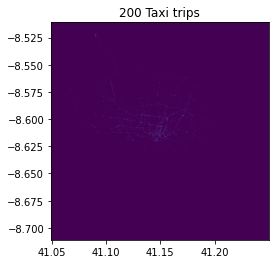

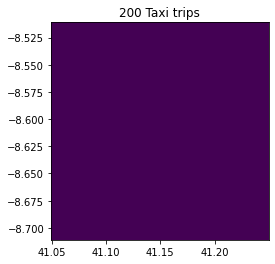

In [7]:
# ###############  TRAINING PARAMETERS  ############
ntrips_train = 200  # num of trips to be read from the file each time
ntrips_test = 300  # num of trips to be read from the file each time
washout_fraction = 0.2
save_results = True
savedir = "/Users/rupesh/Desktop/COD/Duoro_Hawk_Flying_Taxis/"
paramfile = savedir + "hyp_param_df.csv"

# ###############  DATA LOADING AND PREPROCESSING  ##############
data_train, data_valid, Tcollected, norm_param \
    = load_data(ntrips_train, ntrips_test, washout_fraction)

# ###############  TRAINING  ###################
NrList = [80, 120, 250]  # , 500, 100, 50]  # , 1000]
rhoList = [0.4, 0.6, 0.8, 0.9, 1]  # , 0.90, 0.99, 1.25, 1.50]
aList = [0.4, 0.8, 1]
LambdaList = [1e-4, 1e-3, 1e-2, 0.1]  # , 1e-7, 1e-6, 1e-4]
connList = [30]
hyper_lists = (NrList, rhoList, aList, LambdaList, connList)

Nu = Ny = 2
net_param = {'Nu': Nu, 'Ny': Ny, 'use_lsv': True,
             'Nr': 250, 'a': 1, 'rho': 0.4, 'Lambda': 0.01,
             'conn': 30}

# do the parameters grid search
# and update the net params with the winning ones
model_selection = True
if model_selection:
    hyp_param_df = model_selection2(net_param, data_train, Tcollected,
                                    data_valid, norm_param, hyper_lists,
                                    washout_fraction=washout_fraction)
    print("ended with:"),
    winning = hyp_param_df.iloc[hyp_param_df["MHDts"].idxmin()]
    print(winning)

    if save_results:
        print("saving model selection results")
        hyp_param_df.to_csv(paramfile, index=False)
    print ("run the best model")
    net_param['Nr'] = winning['Nr']
    net_param['rho'] = winning['rho']
    net_param['Lambda'] = winning['Lambda']
    net_param['a'] = winning['a']

# ###############  WINNER TRAIN  ###########
# load more data for the test
net = trainEsn(net_param, data_train, Tcollected, washout_fraction)

# ###############  OFFICIAL SUBMISSION GENERATION #################
# applyAndSubmit(net, norm_param, washout_fraction)
# exit()

# ###############  Train TEST #########
MHD = applyAndMhd(net, data_train, norm_param, washout_fraction)
print ("mean Haversine Distance: km " + str(MHD))

# ###############  VALIDATION TEST #########
MHD = applyAndMhd(net, data_valid, norm_param, washout_fraction)
print ("mean Haversine Distance: km " + str(MHD))

# save the bar plot of Wout
if save_results:
    figure()
    bar(range(2 * int(1 + Nu + net.Nr)), net.W_out.T.flatten())
    title('Output weights $\mathbf{W}^{out}$')
    savefig(savedir + 'Wout.png')

    # figure()
    # plot(X[0:20, 0:200].T)
    # title('Some reservoir activations $\mathbf{x}(n)$')
